In [1]:
library(nortest)
library(ggplot2)
library(tidyverse)
library(stringr)
library(effsize)
library(fdrtool)
library(pwr)

-- Attaching packages --------------------------------------- tidyverse 1.3.0 --

v tibble  2.1.3     v dplyr   0.8.3
v tidyr   1.0.0     v stringr 1.4.0
v readr   1.3.1     v forcats 0.4.0
v purrr   0.3.3     

-- Conflicts ------------------------------------------ tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()



distribution tests of spectral bins
Anderson-Darling statistic
null H: the sample distribution is the same as a normal distribution
alt H: sample sitribution is NOT the same as a normal distribution
https://www.rdocumentation.org/packages/nortest/versions/1.0-4/topics/ad.test
wilcoxon
https://stat.ethz.ch/R-manual/R-devel/library/stats/html/wilcox.test.html

In [2]:
# user defined categories for cases and control
status_col_name <- 'Factor.Value.Breast.cancer.diagnosis.'
case_label <- "Metastatic"
control_label <- "Early"
# load and set variables
huna_init <- read.csv('/Users/morris/Box/Hall_Lab/Projects/HUNA/MTBLS424/MTBLS424_init.csv',
                      header=TRUE, check.names=FALSE)
nrow <- nrow(huna_init)
print('assigned variables:')
for (i in 1:nrow){
    assign(toString(huna_init$type[i]), toString(huna_init$path[i]))
    print(toString(huna_init$type[i]))
}
sample_labels_header <- as.list(strsplit(sample_labels_header, " ")[[1]])

[1] "assigned variables:"
[1] "setwd_path"
[1] "data_set_root_dir"
[1] "path_to_fid"
[1] "norm_bin_500_path"
[1] "norm_bin_5000_path"
[1] "bin500_for_sig_tests"
[1] "figure_path"
[1] "sample_labels_header"


In [3]:
length(sample_labels_header)

[1] 4

In [4]:
# import NMR spectral bin data with real number values and labels
nmr_w_labels <- read.csv(file=bin500_for_sig_tests, header=TRUE, sep=",")

In [5]:
index_of_case <- which(nmr_w_labels[,status_col_name] == case_label)
print(index_of_case)
nmr_case <- nmr_w_labels[index_of_case,]
nmr_case <- nmr_case[,2:(ncol(nmr_case)-length(sample_labels_header))]
print(nrow(nmr_case))

index_of_control <- which(nmr_w_labels[,status_col_name] == control_label)
nmr_control <- nmr_w_labels[index_of_control,]
nmr_control <- nmr_control[,2:(ncol(nmr_control)-length(sample_labels_header))]
print(nrow(nmr_control))

  [1] 591 592 593 594 595 596 597 598 599 600 601 602 603 604 605 606 607 608
 [19] 609 610 611 612 613 614 615 616 617 618 619 620 621 622 623 624 625 626
 [37] 627 628 629 630 631 632 633 634 635 636 637 638 639 640 641 642 643 644
 [55] 645 646 647 648 649 650 651 652 653 654 655 656 657 658 659 660 661 662
 [73] 663 664 665 666 667 668 669 670 671 672 673 674 675 676 677 678 679 680
 [91] 681 682 683 684 685 686 687 688 689 690 691 692 693 694 695 696 697 698
[109] 699
[1] 109
[1] 590


In [6]:
create_adtest_pval_col <- function(data){
    pvalue_col <- c()
    for (i in 1:(ncol(data))){
        ad_result <- ad.test(data[,i])
        pvalue <- as.numeric(ad_result['p.value'])
        pvalue_col <- c(pvalue_col, pvalue)
    }
    Spectral_Bin <- colnames(data)
    df <- as.data.frame(Spectral_Bin)
    df["A.D._Test_Pvalue"] <- pvalue_col
    return(df)
}

In [7]:
nmr_case_adtest <- create_adtest_pval_col(nmr_case)
nmr_control_adtest <- create_adtest_pval_col(nmr_control)

In [8]:
nmr_case_adtest$A.D._Test_Sig <- FALSE
nmr_case_adtest$A.D._Test_Sig[nmr_case_adtest$A.D._Test_Pvalue <= 0.05] <- TRUE
nmr_case_adtest$A.D._Test_Sig_Bonferroni <- FALSE
nmr_case_adtest$A.D._Test_Sig_Bonferroni[nmr_case_adtest$A.D._Test_Pvalue <= 0.05/nrow(nmr_case_adtest)] <- TRUE

nmr_control_adtest$A.D._Test_Sig <- FALSE
nmr_control_adtest$A.D._Test_Sig[nmr_control_adtest$A.D._Test_Pvalue <= 0.05] <- TRUE
nmr_control_adtest$A.D._Test_Sig_Bonferroni <- FALSE
nmr_control_adtest$A.D._Test_Sig_Bonferroni[nmr_control_adtest$A.D._Test_Pvalue <= 0.05/nrow(nmr_control)] <- TRUE

In [9]:
cat(data_set_root_dir,"data set: number of case samples without bonferroni correction: ",
    length(which(nmr_case_adtest$A.D._Test_Sig)), " WITH bonferroni correction: ",
    length(which(nmr_case_adtest$A.D._Test_Sig_Bonferroni)), "\n")
cat(data_set_root_dir,"data set: number of control samples without bonferroni correction: ",
    length(which(nmr_control_adtest$A.D._Test_Sig)), " WITH bonferroni correction: ",
    length(which(nmr_control_adtest$A.D._Test_Sig_Bonferroni)), "\n", "\n")

MTBLS424 data set: number of case samples without bonferroni correction:  244  WITH bonferroni correction:  185 
MTBLS424 data set: number of control samples without bonferroni correction:  453  WITH bonferroni correction:  435 
 


In [10]:
wilcoxon_twosided <- function(spectral_bin_case, spectral_bin_control, adtest_results){
    pvalue_col <- c()
    for (i in 1:(ncol(spectral_bin_case))){
        wilcoxon_result <- wilcox.test(spectral_bin_case[,i],
                                       spectral_bin_control[,i],
                                       alternative= "two.sided",
                                       exact=TRUE)
        pvalue <- as.numeric(wilcoxon_result['p.value'])
        pvalue_col <- c(pvalue_col, pvalue)
    }
    Spectral_Bin <- colnames(data)
    adtest_results["Wilcoxon_Pvalues"] <- pvalue_col
    adtest_results$WRS_Test_Sig <- FALSE
    adtest_results$WRS_Test_Sig[adtest_results$Wilcoxon_Pvalues <= 0.05] <- TRUE
    adtest_results$WRS_Test_Sig_Bonferroni <- FALSE
    adtest_results$WRS_Test_Sig_Bonferroni[adtest_results$Wilcoxon_Pvalues <= 0.05/nrow(adtest_results)] <- TRUE
    return(adtest_results)
}

In [11]:
nmr_adtest_WRS <- wilcoxon_twosided(nmr_case, nmr_control, nmr_case_adtest)

Warning message in wilcox.test.default(spectral_bin_case[, i], spectral_bin_control[, :
"cannot compute exact p-value with ties"
Warning message in wilcox.test.default(spectral_bin_case[, i], spectral_bin_control[, :
"cannot compute exact p-value with ties"
Warning message in wilcox.test.default(spectral_bin_case[, i], spectral_bin_control[, :
"cannot compute exact p-value with ties"
Warning message in wilcox.test.default(spectral_bin_case[, i], spectral_bin_control[, :
"cannot compute exact p-value with ties"
Warning message in wilcox.test.default(spectral_bin_case[, i], spectral_bin_control[, :
"cannot compute exact p-value with ties"
Warning message in wilcox.test.default(spectral_bin_case[, i], spectral_bin_control[, :
"cannot compute exact p-value with ties"
Warning message in wilcox.test.default(spectral_bin_case[, i], spectral_bin_control[, :
"cannot compute exact p-value with ties"
Warning message in wilcox.test.default(spectral_bin_case[, i], spectral_bin_control[, :
"cannot c

In [12]:
cat(data_set_root_dir,"data set: number of significant samples without bonferroni correction: ",
    length(which((nmr_adtest_WRS$WRS_Test_Sig))), " WITH bonferroni correction: ",
    length(which((nmr_adtest_WRS$WRS_Test_Sig_Bonferroni))), "\n","\n")


MTBLS424 data set: number of significant samples without bonferroni correction:  264  WITH bonferroni correction:  136 
 


In [13]:
manh_plot_path <- paste(setwd_path, data_set_root_dir, '/output/figures/', data_set_root_dir,
                       '_manh_plot_significant_bins_diagnosis',
                        case_label, '_vs_', control_label, '.png', sep='')

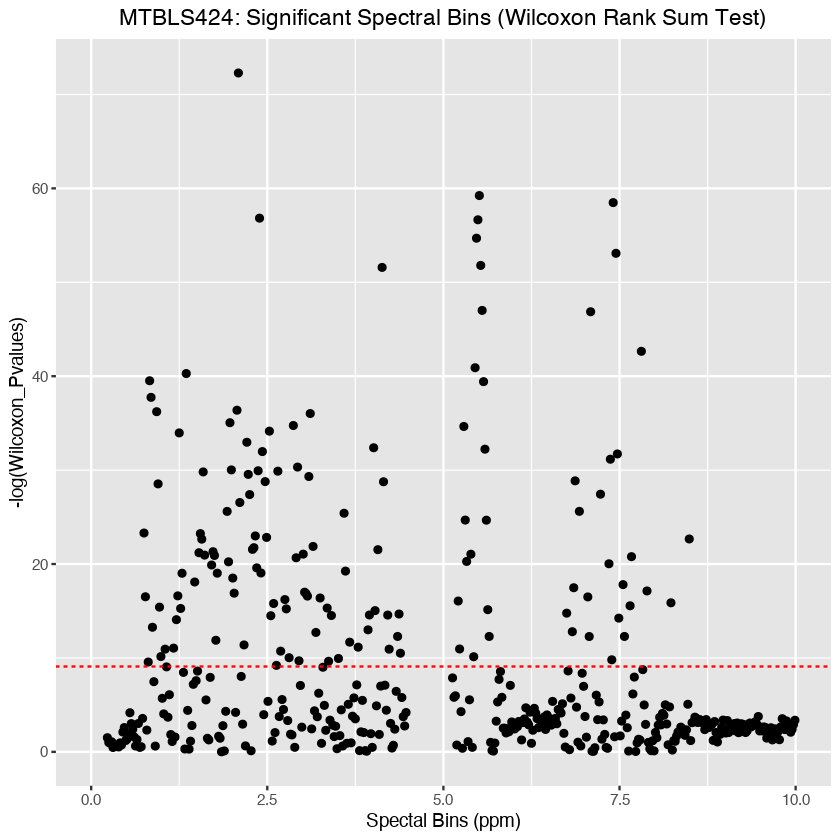

In [14]:
spectral_bin_num <- apply(nmr_adtest_WRS[1], 2, str_sub, start=2)
#head(spectral_bin_num)
spectral_bin_num <- apply(spectral_bin_num, 2, as.numeric)
spectral_bin_num <- as.data.frame(spectral_bin_num)
colnames(spectral_bin_num)[colnames(spectral_bin_num)=="Spectral_Bin"] <- "Numeric_Spectral_Bin"
spectral_pval_df_numericBinNames <- cbind(spectral_bin_num, nmr_adtest_WRS)
g <- ggplot(data=spectral_pval_df_numericBinNames, aes(x=Numeric_Spectral_Bin, y=-log(Wilcoxon_Pvalues))) + geom_point()
g <- g + ggtitle(paste(data_set_root_dir, ": Significant Spectral Bins (Wilcoxon Rank Sum Test)", sep='')) 
g <- g + theme(plot.title = element_text(hjust = 0.5))
g <- g + geom_hline(yintercept = (-log(0.05/nrow(nmr_adtest_WRS))), color = "red", linetype = "dashed")
g <- g + xlab ("Spectal Bins (ppm)")
g <- g + scale_x_continuous(limits = c(0, 10))
g <- g + theme(panel.background = element_rect(fill = "grey90"))
g
ggsave(file= manh_plot_path, width=12, height=4, dpi='retina')

### Cohen's D calculations

In [15]:
cohenD <- function(spectral_bin_case, spectral_bin_control, adtest_results){
    effectsize_col <- c()
    magnitude_col <- c()
    for (i in 1:(ncol(spectral_bin_case))){
        control_itercol = spectral_bin_control[,i]
        case_itercol = spectral_bin_case[,i]
        cohen_result <- cohen.d(case_itercol,control_itercol)
        d <- cohen_result$estimate
        mag <- toString(cohen_result$magnitude)
        effectsize_col <- c(effectsize_col, d)
        magnitude_col <- c(magnitude_col, mag)
    }
    #Spectral_Bin <- colnames(data)
    adtest_results["Cohens_D"] <- effectsize_col
    adtest_results["Cohens_D_magnitude"] <- magnitude_col
    return(adtest_results)
}

In [16]:
nmr_adtest_WRS_Cohen <- cohenD(nmr_case, nmr_control, nmr_adtest_WRS)

In [17]:
nmr_WRSB_Sig <-which((nmr_adtest_WRS_Cohen$WRS_Test_Sig_Bonferroni))
length(nmr_WRSB_Sig)

[1] 136

In [18]:
# create dateframe that contain only the Bonferroni significant samples.
nmr_Bsig_Cohen <- nmr_adtest_WRS_Cohen[nmr_WRSB_Sig,]

In [19]:
# finding all spectral bins that are Bonferroni significant AND have medium and large
# effect sizes
nmr_Bsig_Cohen_medium <- nmr_Bsig_Cohen[nmr_Bsig_Cohen$Cohens_D_magnitude == 'medium',]
print(paste('Number of spectral bins with medium effect size: ',nrow(nmr_Bsig_Cohen_medium)))
nmr_Bsig_Cohen_large <- nmr_Bsig_Cohen[nmr_Bsig_Cohen$Cohens_D_magnitude == 'large',]
print(paste('Number of spectral bins with large effect size: ',nrow(nmr_Bsig_Cohen_large)))
nmr_Bsig_Cohen_medandlarge <- rbind(nmr_Bsig_Cohen_medium, nmr_Bsig_Cohen_large)
bonf_sig_index <- which(nmr_Bsig_Cohen_medandlarge$WRS_Test_Sig_Bonferroni)
nmr_Bsig_Cohen_medandlarge_BonfSig <- nmr_Bsig_Cohen_medandlarge[bonf_sig_index,]
print(nrow(nmr_Bsig_Cohen_medandlarge_BonfSig))

[1] "Number of spectral bins with medium effect size:  35"
[1] "Number of spectral bins with large effect size:  32"
[1] 67


In [20]:
cat(data_set_root_dir, ": number of Bonferroni significant samples alone: ",
    length(which((nmr_adtest_WRS_Cohen$WRS_Test_Sig_Bonferroni))), "\n",
    data_set_root_dir,
    ": number samples with Bonferroni significant and Medium and Large Cohen's D effect size: ",
    nrow(nmr_Bsig_Cohen_medandlarge_BonfSig), "\n")

MTBLS424 : number of Bonferroni significant samples alone:  136 
 MTBLS424 : number samples with Bonferroni significant and Medium and Large Cohen's D effect size:  67 


In [21]:
length(nmr_adtest_WRS_Cohen$WRS_Test_Sig_Bonferroni == TRUE)

[1] 457

In [22]:
manh_cohen_volcano_plot_path <- paste(setwd_path, data_set_root_dir, '/output/figures/',
                                      data_set_root_dir, '_manh_plot_cohen_volcano_diagnosis',
                                      case_label, '_vs_', control_label, '.png',
                                      sep='')

In [23]:
xmax <- max(nmr_adtest_WRS_Cohen$Cohens_D, na.rm = TRUE)
xmin <- min(nmr_adtest_WRS_Cohen$Cohens_D, na.rm = TRUE)
ymax <- -log10(min(nmr_adtest_WRS_Cohen$Wilcoxon_Pvalues, na.rm = TRUE))
yint_value <- -log(0.05/nrow(nmr_adtest_WRS_Cohen))
g = ggplot(data=nmr_adtest_WRS_Cohen, aes(x=Cohens_D, y=-log10(Wilcoxon_Pvalues))) +
geom_point(aes(colour = Cohens_D_magnitude), size=2) +
scale_colour_manual(values = c("small"= "yellow", "medium"="orange",  "large"= "red", 'negligible'="grey"))+
geom_point(alpha=0.2, size=5) +
theme(legend.position = "right") +
xlim(c(xmin, xmax)) +
ylim(c(0,ymax)) +
geom_hline(yintercept = yint_value, color = "blue", linetype = "dashed")+
xlab("Cohen's D") + ylab("-log10 p-value")

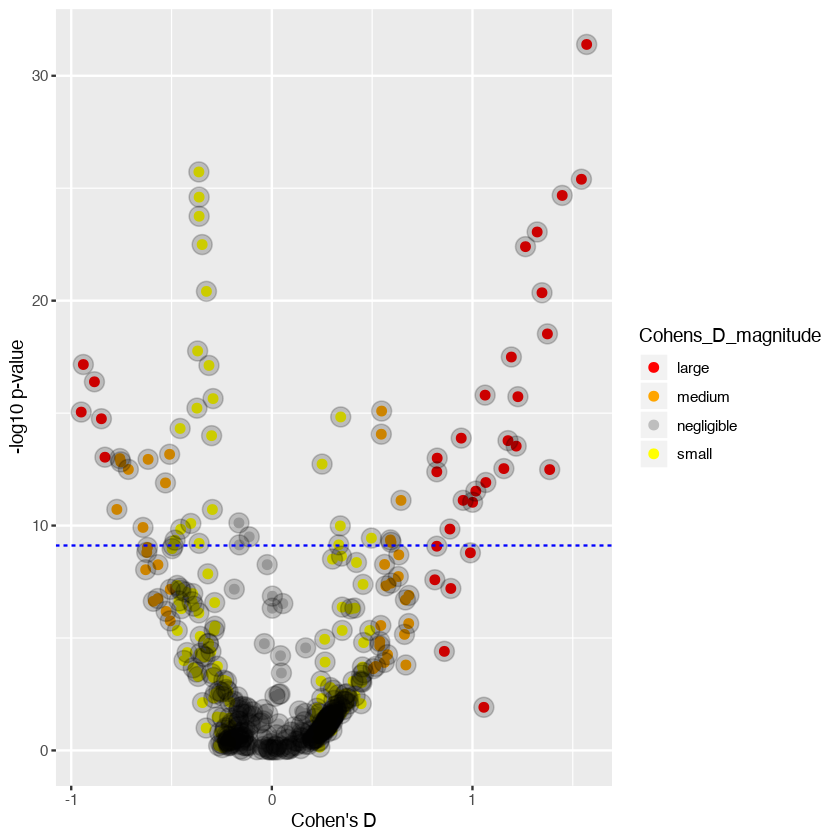

In [24]:
g
ggsave(file= manh_cohen_volcano_plot_path, width=8, height=4, dpi='retina')

### Statistical Power Thresholds

In [25]:
n_nmr_case <- nrow(nmr_case)
n_nmr_control <- nrow(nmr_control)
if (n_nmr_case < n_nmr_control){
    n = n_nmr_case
} else if (n_nmr_case > n_nmr_control | n_nmr_case == n_nmr_control){
    n = n_nmr_control
}
power_stats <- pwr.t.test(n = n,                  # Observations in _each_ group
                          d = NULL,           
                          sig.level = 0.05/nrow(nmr_adtest_WRS_Cohen),      # Type I probability
                          power = 0.80,              # 1 minus Type II probability
                          type = "two.sample",       # Change for one- or two-sample
                          alternative = "two.sided")

In [41]:
d <- power_stats[2]
d <- as.numeric(unlist(d))
# absolute value of Cohen's d effect size threshold that meets a power value of >=80%
nmr_adtest_WRS_Cohen$Power_CohenVal_Threshold <- FALSE
nmr_adtest_WRS_Cohen$Power_CohenVal_Threshold[nmr_adtest_WRS_Cohen$Cohens_D >= d] <- TRUE
nmr_adtest_WRS_Cohen$Power_CohenVal_Threshold[nmr_adtest_WRS_Cohen$Cohens_D >= (-d)] <- TRUE

In [42]:
cat(data_set_root_dir, ": number of spectral bins with sufficient power: ",
    length(which((nmr_adtest_WRS_Cohen$Power_CohenVal_Threshold))))

MTBLS424 : number of spectral bins with sufficient power:  448

In [43]:
xmax <- max(nmr_adtest_WRS_Cohen$Cohens_D, na.rm = TRUE)
xmin <- min(nmr_adtest_WRS_Cohen$Cohens_D, na.rm = TRUE)
ymax <- -log10(min(nmr_adtest_WRS_Cohen$Wilcoxon_Pvalues, na.rm = TRUE))
yint_value <- -log(0.05/nrow(nmr_adtest_WRS_Cohen))
g = ggplot(data=nmr_adtest_WRS_Cohen, aes(x=Cohens_D, y=-log10(Wilcoxon_Pvalues))) +
geom_point(aes(colour = Cohens_D_magnitude), size=2) +
scale_colour_manual(values = c("small"= "yellow", "medium"="orange",  "large"= "red", 'negligible'="grey"))+
geom_point(alpha=0.2, size=5) +
theme(legend.position = "right") +
xlim(c(xmin, xmax)) +
ylim(c(0,ymax)) +
geom_hline(yintercept = yint_value, color = "blue", linetype = "dashed")+
geom_vline(xintercept = c(d,-d), color = "blue", linetype = "dashed")+
xlab("Cohen's D") + ylab("-log10 p-value")+
ggtitle(paste(data_set_root_dir,
                       ": Significant Spectral Bins \n (Wilcoxon Rank Sum Test Bonferroni Corrected)", sep='')) 


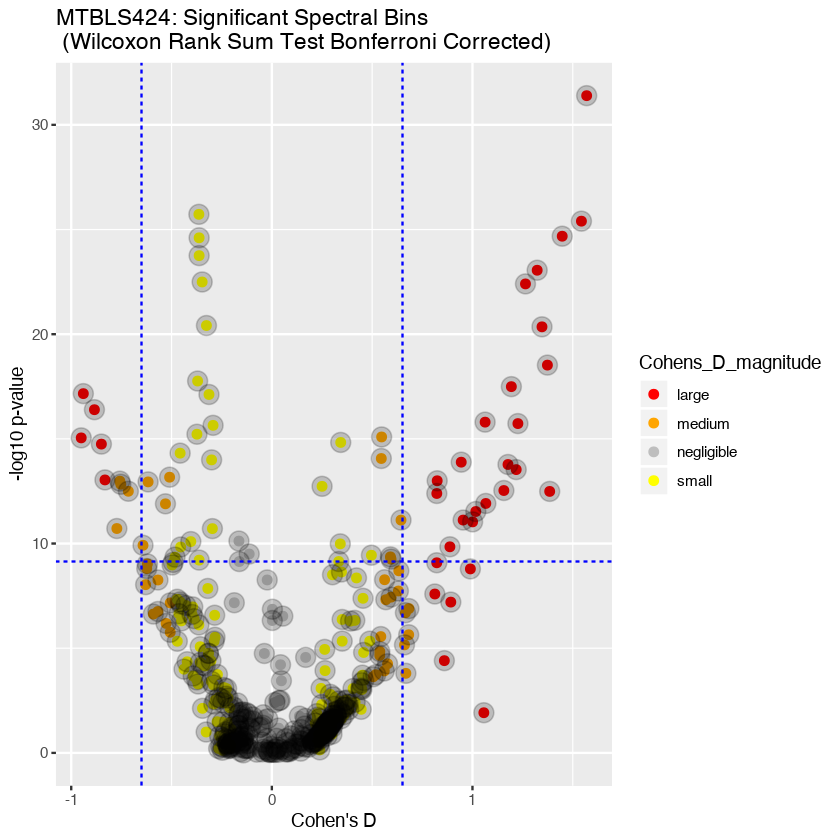

In [44]:
g
manh_cohen_power_volcano_plot_path <- paste(setwd_path, data_set_root_dir, '/output/figures/',
                                            data_set_root_dir,'_manh_plot_cohen_power_volcano_diagnosis',
                                            case_label, '_vs_', control_label, '.png',
                                            sep='')
ggsave(file= manh_cohen_power_volcano_plot_path, width=8, height=4, dpi='retina')

### FDR (Benjamini-Hochberg) analysis

In [45]:
nmr_adtest_WRS_Cohen$FDR_BH_Pvalues <- p.adjust(nmr_adtest_WRS_Cohen$Wilcoxon_Pvalues,
                                                method = "BH")

In [46]:
nmr_adtest_WRS_Cohen$FDR_BH_Pvalues_Sig <- FALSE
nmr_adtest_WRS_Cohen$FDR_BH_Pvalues_Sig[nmr_adtest_WRS_Cohen$FDR_BH_Pvalues <= 0.05] <- TRUE

In [47]:
manh_FDR_BH_plot_path <- paste(setwd_path, data_set_root_dir, '/output/figures/', data_set_root_dir,
                               '_manh_FDR_BH_diagnosis.png',case_label, '_vs_', control_label,
                               '.png', sep='')

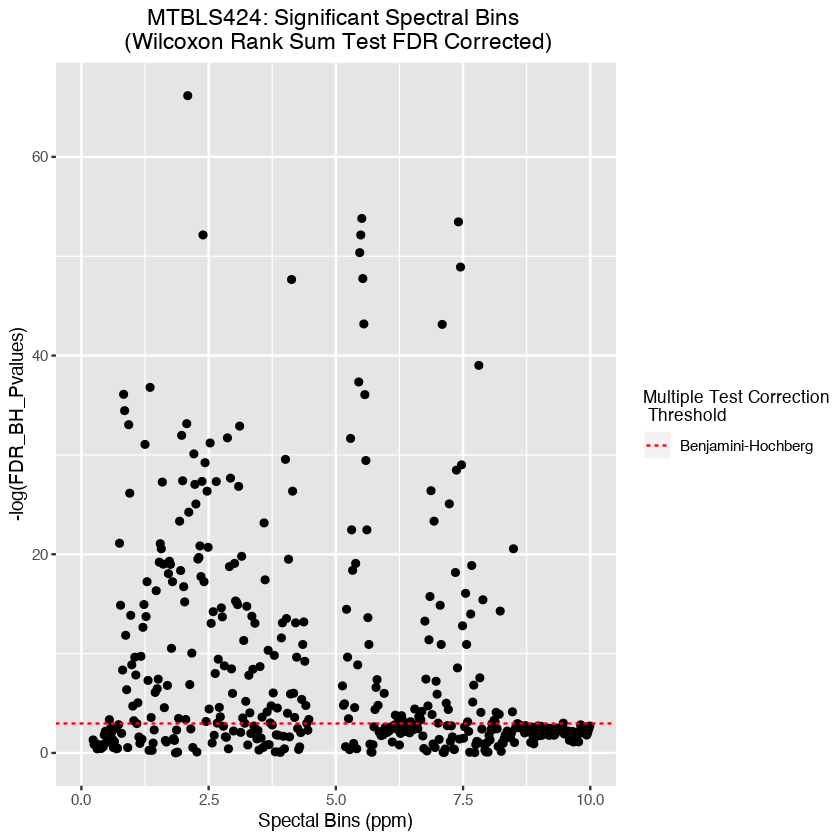

In [48]:
bon <- "Bonferroni"
BH <- "Benjamini-Hochberg"
spectral_bin_num <- apply(nmr_adtest_WRS_Cohen[1], 2, str_sub, start=2)
#head(spectral_bin_num)
spectral_bin_num <- apply(spectral_bin_num, 2, as.numeric)
spectral_bin_num <- as.data.frame(spectral_bin_num)
colnames(spectral_bin_num)[colnames(spectral_bin_num)=="Spectral_Bin"] <- "Numeric_Spectral_Bin"
spectral_pval_df_numericBinNames <- cbind(spectral_bin_num, nmr_adtest_WRS_Cohen)
g <- ggplot(data=spectral_pval_df_numericBinNames,
            aes(x=Numeric_Spectral_Bin, y=-log(FDR_BH_Pvalues))) + geom_point()
g <- g + ggtitle(paste(data_set_root_dir,
                       ": Significant Spectral Bins \n (Wilcoxon Rank Sum Test FDR Corrected)", sep='')) 
g <- g + theme(plot.title = element_text(hjust = 0.5))
g <- g + geom_hline(aes(yintercept = (-log(0.05)), linetype = BH), color = 'red')
g <- g + scale_linetype_manual(name = "Multiple Test Correction \n Threshold", values = c(2, 2), 
                      guide = guide_legend(override.aes = list(color = c("red"))))
g <- g + xlab ("Spectal Bins (ppm)")
g <- g + scale_x_continuous(limits = c(0, 10))
g <- g + theme(panel.background = element_rect(fill = "grey90"))
g <- g + theme(legend.title = element_text(colour="black", size=10))
g
ggsave(file= manh_FDR_BH_plot_path, width=8, height=4, dpi='retina')

In [49]:
cat(data_set_root_dir, ": number of FDR significant samples alone: ",
    length(which((nmr_adtest_WRS_Cohen$FDR_BH_Pvalues_Sig))), "\n",
    data_set_root_dir,
    ": number samples with Bonferroni significant and Medium and Large Cohen's D effect size: ",
    nrow(nmr_Bsig_Cohen_medandlarge_BonfSig), "\n")

MTBLS424 : number of FDR significant samples alone:  214 
 MTBLS424 : number samples with Bonferroni significant and Medium and Large Cohen's D effect size:  67 


In [50]:
stat_results_data_path = paste(setwd_path, data_set_root_dir, '/output/', data_set_root_dir,
                               '_all_stat_results_diagnosis', case_label, '_vs_', control_label,
                               '.csv', sep='')
BonSig_Cohen_results_data_path = paste(setwd_path, data_set_root_dir, '/output/', data_set_root_dir,
                                       '_BonSig_Cohen_Power_ROI_results_diagnosis',case_label,
                                       '_vs_', control_label, '.csv', sep='')
write.csv(nmr_adtest_WRS_Cohen, file=stat_results_data_path, row.names=FALSE)
write.csv(nmr_Bsig_Cohen_medandlarge_BonfSig, file=BonSig_Cohen_results_data_path, row.names=FALSE)

In [36]:
# saving the updated the huna init csv file
save <- (paste(setwd_path,'/',data_set_root_dir, '/', data_set_root_dir, '_init.csv', sep=''))
huna_init <- rbind(huna_init, data.frame(type = "stat_results_data_path",
                                         path = stat_results_data_path))
huna_init <- rbind(huna_init, data.frame(type = "BonSig_Cohen_results_data_path",
                                         path = BonSig_Cohen_results_data_path))
write.csv(huna_init, file= save, row.names=FALSE)